In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [3]:
class Experiment:
    def __init__(self,exp_name,file_path):
        self.exp_name = exp_name
        self.file_path = file_path
        self.data = pd.read_csv(self.file_path)
        
        self.BAR_COLOR = {
            "FRONT" : 'red',
            "REAR"  : 'blue',
            "LEFT"  : 'green',
            "RIGHT" : 'gray',
            "TOP"   : "black",
            "BOTTOM" : 'orange'
        }
    def get_avg_values(self,start=0,end=-1,normalize_positions=False):
        if end == -1:
            end = len(self.data)
        self.data = self.data[start:end]
        if normalize_positions:
            for i in range(1,7):
                self.data[f'ACKPOSITIONCH{i}'] = self.data[f'ACKPOSITIONCH{i}'] - self.data[f'ACKPOSITIONCH{i}'].iloc[0]
        avg_positions = self.data['ACKPOSITIONCH1'] + self.data['ACKPOSITIONCH2'] + self.data['ACKPOSITIONCH3'] + self.data['ACKPOSITIONCH4'] + self.data['ACKPOSITIONCH5'] + self.data['ACKPOSITIONCH6']
        avg_positions = avg_positions/6

        avg_pressures = self.data['HYDPRESSURE1'] + self.data['HYDPRESSURE2'] + self.data['HYDPRESSURE3'] + self.data['HYDPRESSURE4'] + self.data['HYDPRESSURE5'] + self.data['HYDPRESSURE6']
        avg_pressures = avg_pressures/6
        return avg_positions,avg_pressures

    def get_time_seconds(self,row):
        current_time = row['TIME1'].split('.')[0]
        stamp = row['DATE1'] + ' ' + current_time
        date_time = datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S')
        unix_timestamp = int(time.mktime(date_time.timetuple()))
        return unix_timestamp

    def plot_by_ids_for_position(self,ID):
        data = {
            'Category': [],
            'FRONT' : [],
            'REAR' : [],
            'LEFT' : [],
            'RIGHT' : [],
            'TOP' : [],
            'BOTTOM' : [],
        }
        first_timestamp = self.get_time_seconds(self.data.iloc[0])
        for time_id in ID:
            row = self.data[self.data['ID'] == time_id].iloc[0]
            data['FRONT'].append(row['ACKPOSITIONCH1'])
            data['REAR'].append(row['ACKPOSITIONCH2'])
            data['LEFT'].append(row['ACKPOSITIONCH3'])
            data['RIGHT'].append(row['ACKPOSITIONCH4'])
            data['TOP'].append(row['ACKPOSITIONCH5'])
            data['BOTTOM'].append(row['ACKPOSITIONCH6'])

            average_pressure = row['HYDPRESSURE1'] + row['HYDPRESSURE2'] + row['HYDPRESSURE3'] + row['HYDPRESSURE4'] + row['HYDPRESSURE5'] + row['HYDPRESSURE6']
            average_pressure = round(average_pressure/6,2)
            this_timestamp = self.get_time_seconds(row)
            relative_time = this_timestamp - first_timestamp
            data['Category'].append(average_pressure)
            
        df = pd.DataFrame(data)
        categories = df['Category']

        groups = df.columns[1:]

        x = np.arange(len(categories))
        width = 0.8 / len(groups)

        fig, ax = plt.subplots(figsize=(16, 9))
        for i, group in enumerate(groups):
            color = self.BAR_COLOR[group]
            ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

        ax.set_xlabel('Average Pressure')
        ax.set_ylabel('Position Stroke')
        ax.set_title(f'{self.exp_name} - Position Stroke vs Average Pressure')
        
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_by_ids_for_pressure(self,ID):
        data = {
            'Category': [],
            'FRONT' : [],
            'REAR' : [],
            'LEFT' : [],
            'RIGHT' : [],
            'TOP' : [],
            'BOTTOM' : [],
        }
        first_timestamp = self.get_time_seconds(self.data.iloc[0])
        for time_id in ID:
            row = self.data[self.data['ID'] == time_id].iloc[0]
            data['FRONT'].append(row['HYDPRESSURE1'])
            data['REAR'].append(row['HYDPRESSURE2'])
            data['LEFT'].append(row['HYDPRESSURE3'])
            data['RIGHT'].append(row['HYDPRESSURE4'])
            data['TOP'].append(row['HYDPRESSURE5'])
            data['BOTTOM'].append(row['HYDPRESSURE6'])
            average_pressure = row['HYDPRESSURE1'] + row['HYDPRESSURE2'] + row['HYDPRESSURE3'] + row['HYDPRESSURE4'] + row['HYDPRESSURE5'] + row['HYDPRESSURE6']
            average_pressure = round(average_pressure/6,2)
            this_timestamp = self.get_time_seconds(row)
            relative_time = this_timestamp - first_timestamp
            data['Category'].append(average_pressure)

        df = pd.DataFrame(data)
        categories = df['Category']

        groups = df.columns[1:]

        x = np.arange(len(categories))
        width = 0.8 / len(groups)

   
        fig, ax = plt.subplots(figsize=(16, 9))
        for i, group in enumerate(groups):
            color = self.BAR_COLOR[group]
            ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

        ax.set_xlabel('Average Pressure')
        ax.set_ylabel('Anvil Pressure')
        ax.set_title(f'{self.exp_name} - Anvil Pressure vs Average Pressure')
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()
        
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [4]:

class DataPlot:
    def __init__(self,name,file_path,start=0,end=-1):
        self.experiment = Experiment(name,file_path)

        calib_avg_pos,calib_avg_press = self.experiment.get_avg_values(start,end)


        self.experiment.data['avg_press'] = calib_avg_press
        self.experiment.data['avg_pos'] = calib_avg_pos

        self.ids = []
        pressure_values = [0,5,10,15,20,25,30,60,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,170,180,190,200,210,215,220]

        found_pressures = []
        for p_value in pressure_values:
            found_data = self.experiment.data[(self.experiment.data['avg_press'] >= p_value) & (self.experiment.data['avg_press'] <= (p_value+5))]
            if len(found_data) > 0:
                self.ids.append(found_data.iloc[0]['ID'])
                found_pressures.append(p_value)
    def plot_position(self):
        self.experiment.plot_by_ids_for_position(self.ids)
    def plot_presssure(self):
        self.experiment.plot_by_ids_for_pressure(self.ids)
        

calib_17 = DataPlot('al-test-feb-17-25','./HP_CALIB_BI_CHN_PYRO_A_060325.csv',start=0,end=-1)


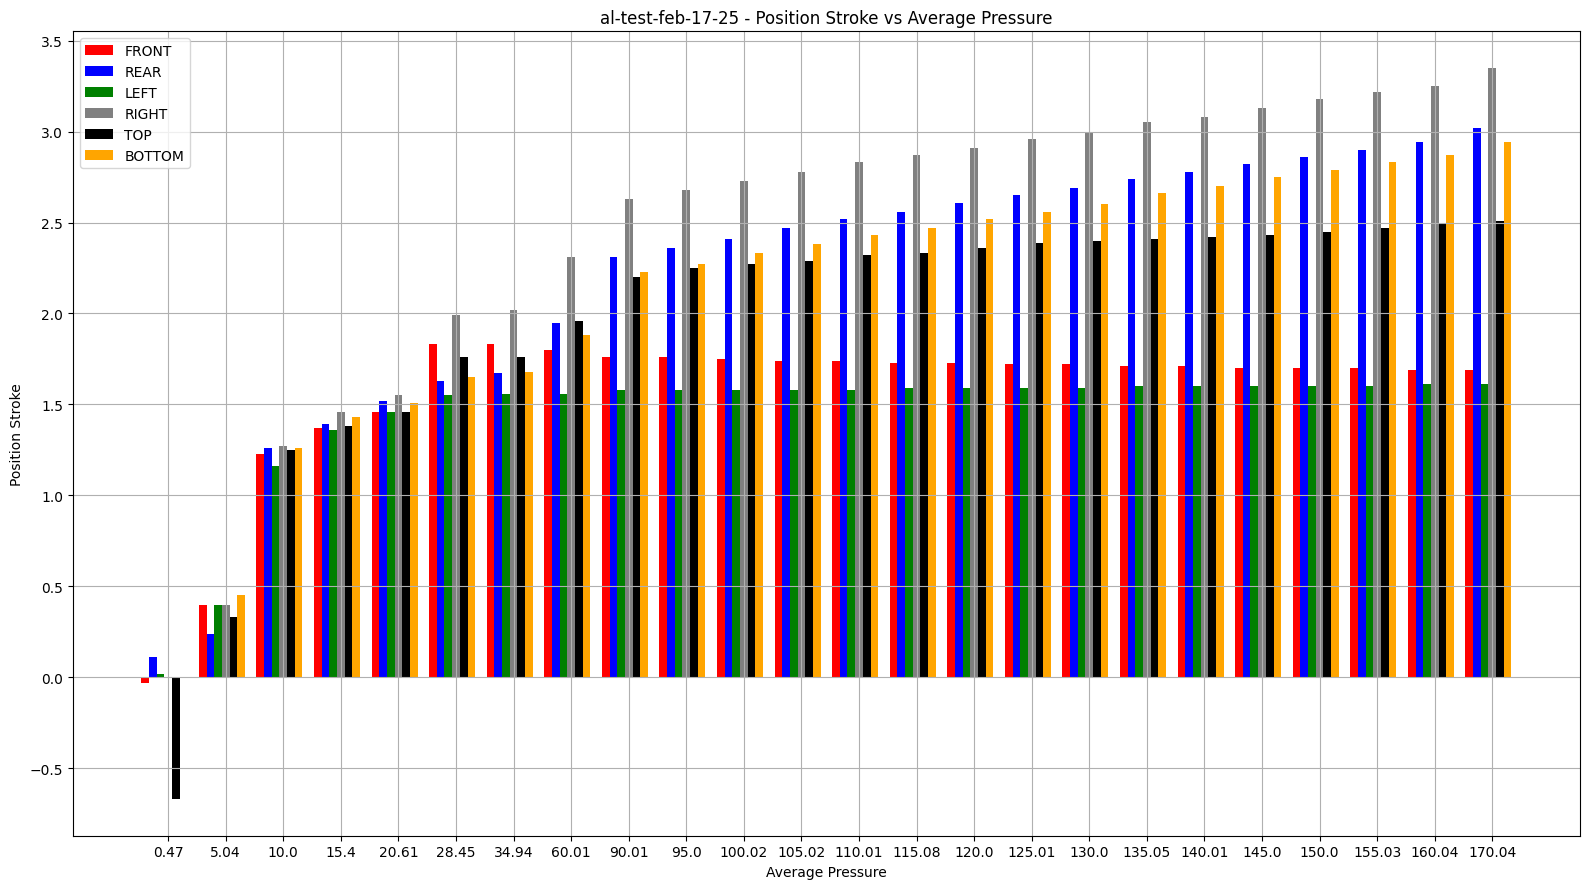

In [5]:
calib_17.plot_position()

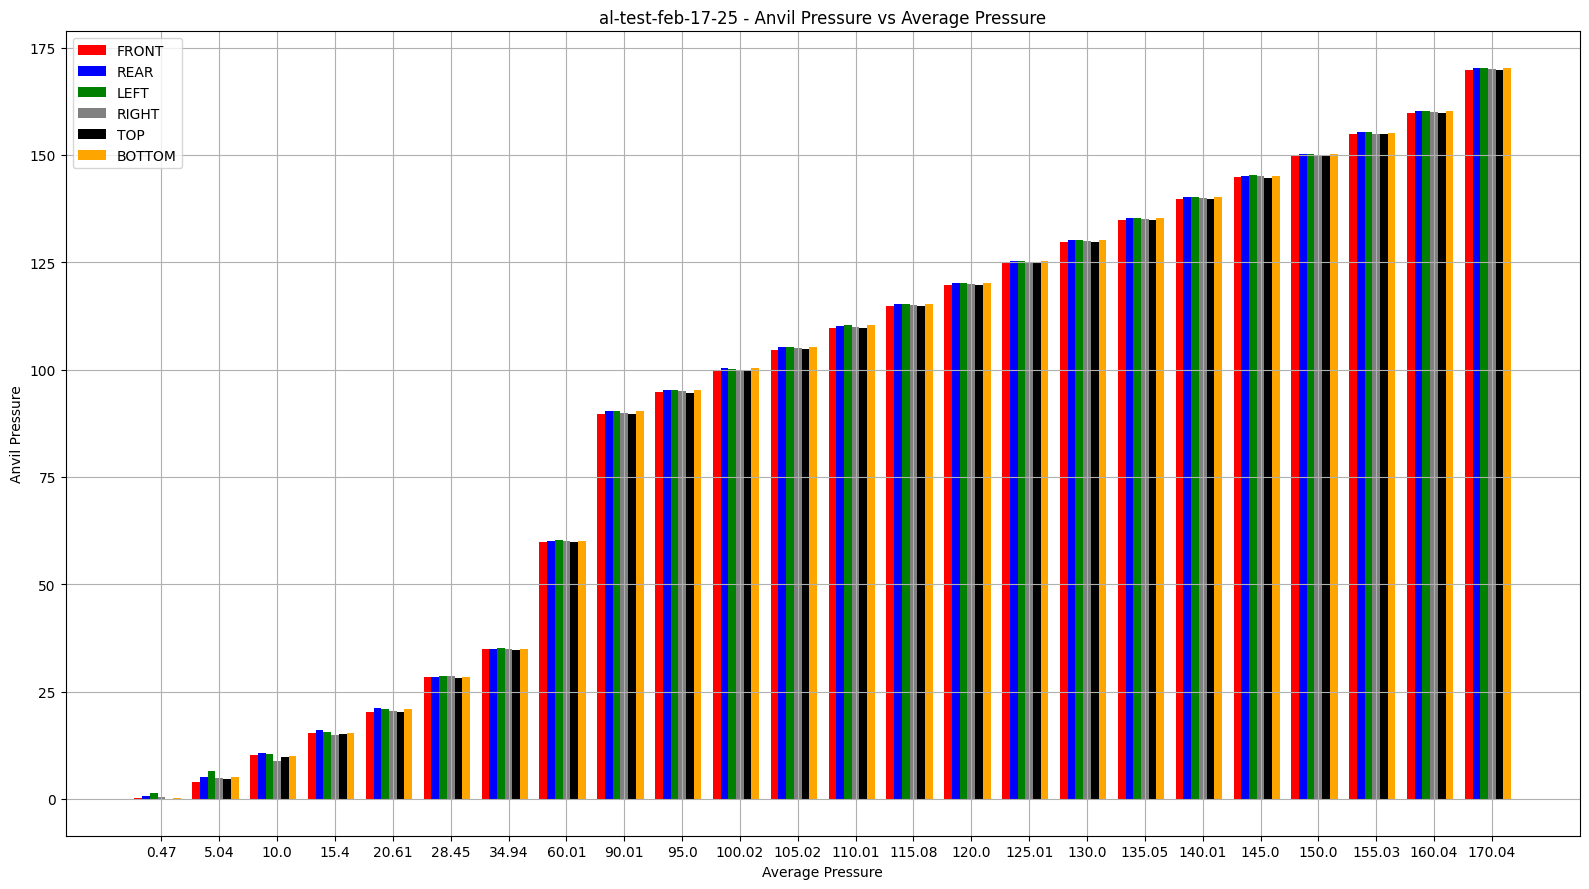

In [6]:
calib_17.plot_presssure()

In [7]:
df = pd.read_csv('./HP_CALIB_BI_CHN_PYRO_A_060325.csv')



date_time= df['DATE1'] +' ' +df['TIME1']
def convert_to_seconds(date_str):
    dt = datetime.strptime(date_str.split('.')[0], "%Y-%m-%d %H:%M:%S")
    return dt.timestamp()

seconds_date_time = date_time.apply(convert_to_seconds)


necessary_df = df[['ACKPOSITIONCH1','ACKPOSITIONCH2','ACKPOSITIONCH3','ACKPOSITIONCH4','ACKPOSITIONCH5','ACKPOSITIONCH6','HYDPRESSURE1','HYDPRESSURE2','HYDPRESSURE3','HYDPRESSURE4','HYDPRESSURE5','HYDPRESSURE6']]
necessary_df = necessary_df.copy()
necessary_df['TIMESTAMP'] = seconds_date_time
necessary_df

print("Before groupby timestamp : ",len(necessary_df))



TIME_DELTA = 60*5
DATA = {}
for index, row in necessary_df.iterrows():
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,timestamp = row
    timestamp = int(timestamp/TIME_DELTA)
    
    if timestamp not in DATA:
        DATA[timestamp] = []
        
    avg_position = (pos1 + pos2 + pos3 + pos4 + pos5+pos6)/6
    avg_pressure = (pressure1 + pressure2 + pressure3 + pressure4 + pressure5 + pressure6)/6
    DATA[timestamp].append([pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure])
    

avg_len = 0
count = 0
NEW_DATA = {}
for timestamp in DATA:
    avg_len += len(DATA[timestamp])
    count+=1
    avg_point = [0]*len(DATA[timestamp][0])
    for point in DATA[timestamp]:
        for i in range(len(point)):
            avg_point[i]+=point[i]
    
    for i in range(len(avg_point)):
        avg_point[i]=avg_point[i] / len(DATA[timestamp])
        
    NEW_DATA[timestamp] = avg_point
    
print("Average group length : ",avg_len/count)
print("After groupby timestamp : ",len(NEW_DATA))


# for timestamp in NEW_DATA:
#     print(timestamp,NEW_DATA[timestamp])

Before groupby timestamp :  15496
Average group length :  455.7647058823529
After groupby timestamp :  34


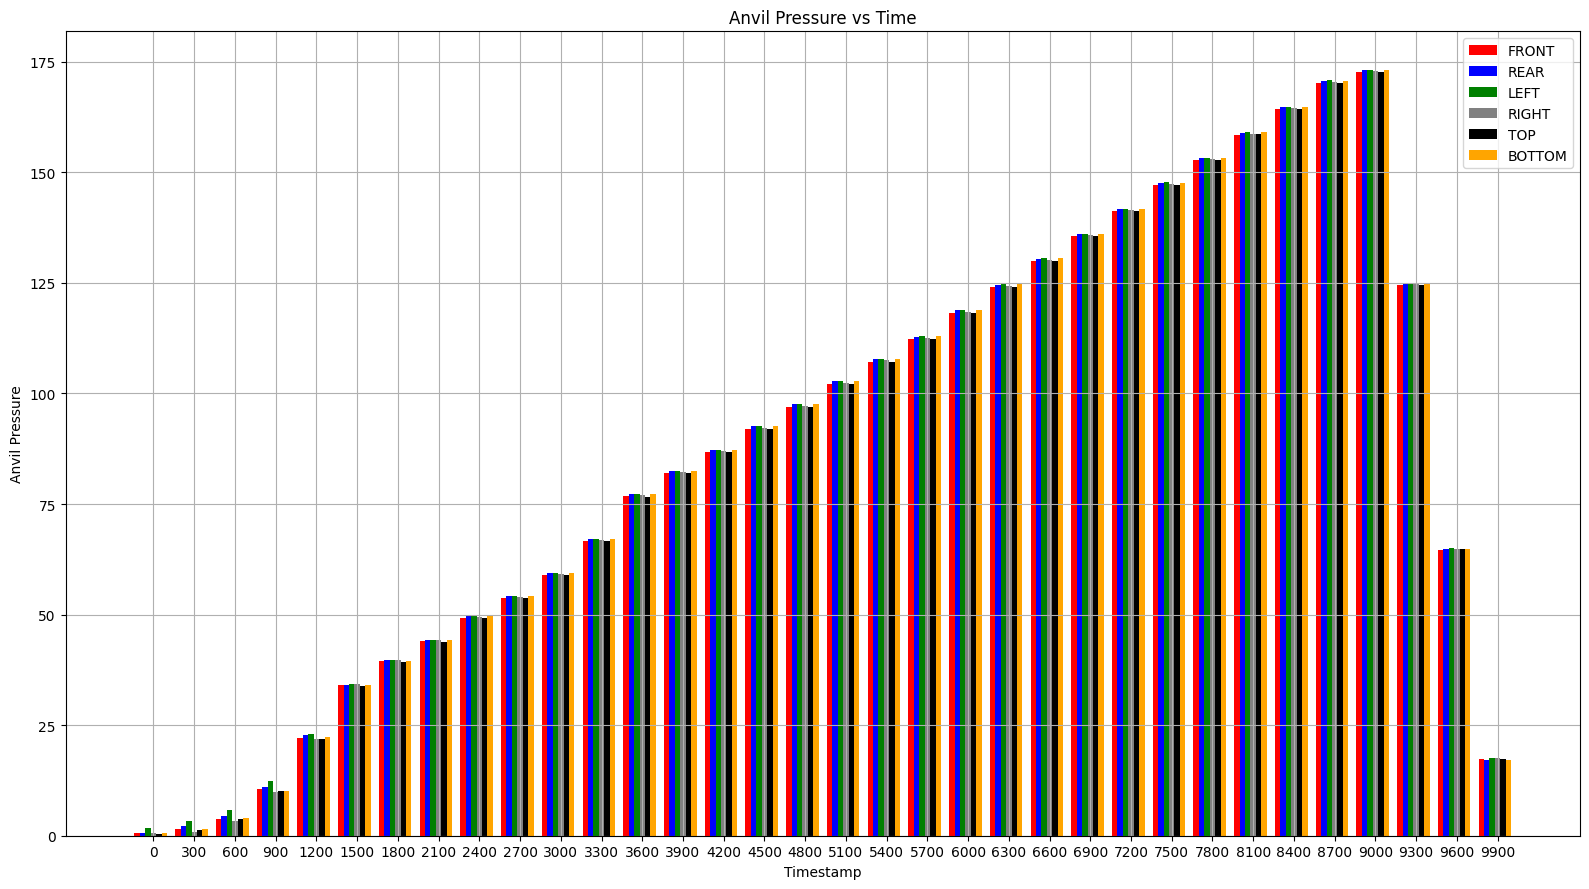

In [8]:
BAR_COLOR = {
            "FRONT" : 'red',
            "REAR"  : 'blue',
            "LEFT"  : 'green',
            "RIGHT" : 'gray',
            "TOP"   : "black",
            "BOTTOM" : 'orange'
        }


data = {
    'Category': [],
    'FRONT' : [],
    'REAR' : [],
    'LEFT' : [],
    'RIGHT' : [],
    'TOP' : [],
    'BOTTOM' : [],
}

START_TIME = 0
for i,timestamp in enumerate(NEW_DATA):
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure = NEW_DATA[timestamp]
    data['FRONT'].append(pressure1)
    data['REAR'].append(pressure2)
    data['LEFT'].append(pressure3)
    data['RIGHT'].append(pressure4)
    data['TOP'].append(pressure5)
    data['BOTTOM'].append(pressure6)
    current_time = START_TIME + i*TIME_DELTA
    data['Category'].append(current_time)
    

df = pd.DataFrame(data)
categories = df['Category']

groups = df.columns[1:]

x = np.arange(len(categories))
width = 0.8 / len(groups)


fig, ax = plt.subplots(figsize=(16, 9))
for i, group in enumerate(groups):
    color = BAR_COLOR[group]
    ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Anvil Pressure')
ax.set_title(f'Anvil Pressure vs Time')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

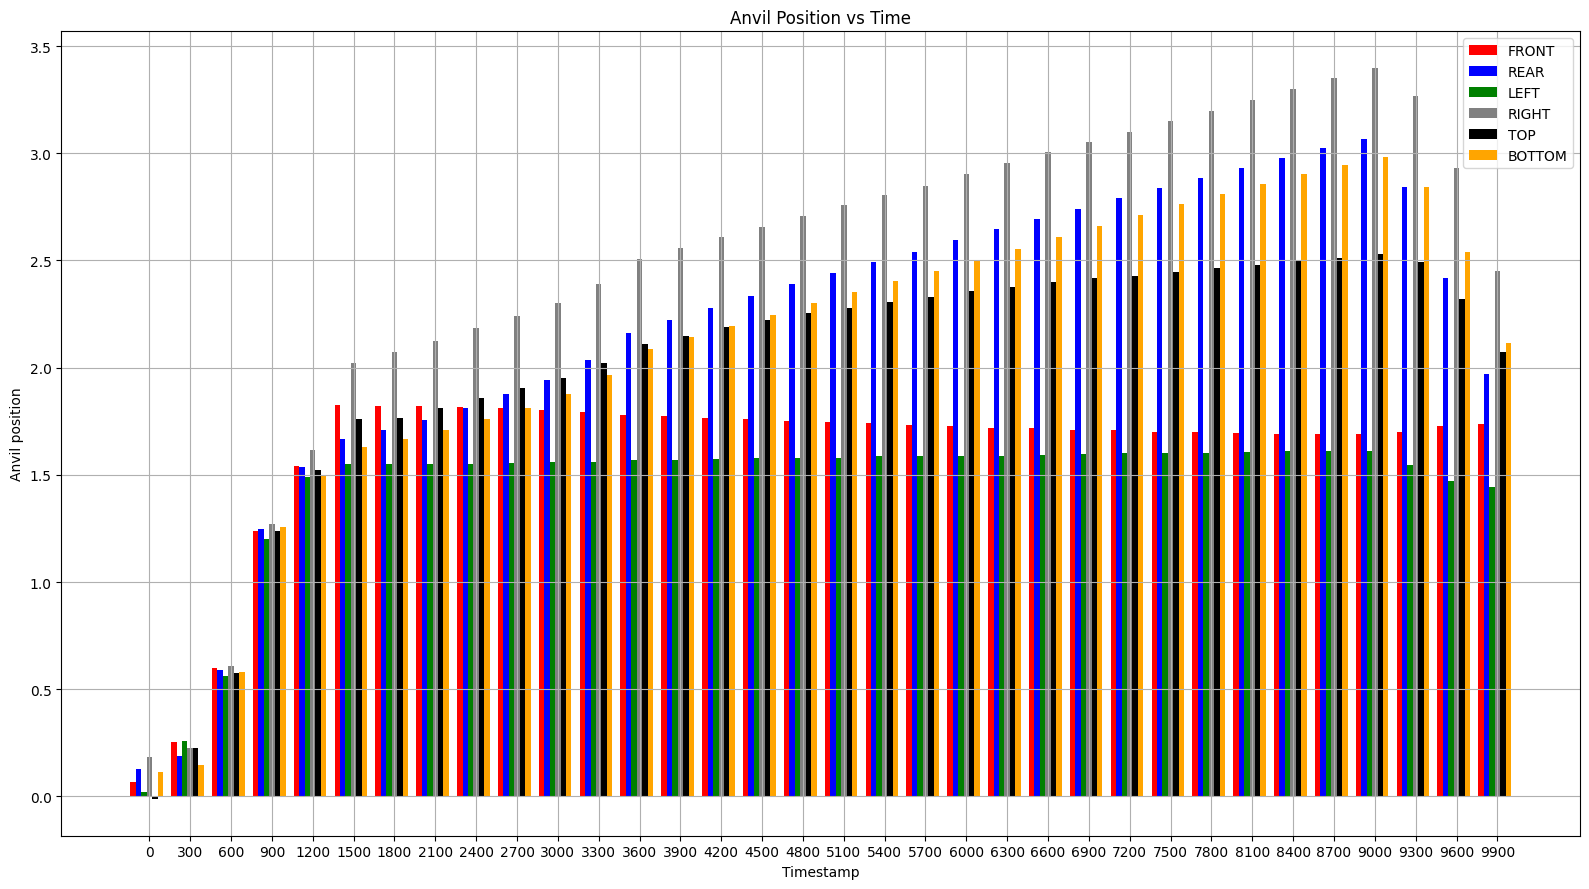

In [9]:

BAR_COLOR = {
            "FRONT" : 'red',
            "REAR"  : 'blue',
            "LEFT"  : 'green',
            "RIGHT" : 'gray',
            "TOP"   : "black",
            "BOTTOM" : 'orange'
        }


data = {
    'Category': [],
    'FRONT' : [],
    'REAR' : [],
    'LEFT' : [],
    'RIGHT' : [],
    'TOP' : [],
    'BOTTOM' : [],
}

START_TIME = 0

for i,timestamp in enumerate(NEW_DATA):
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure = NEW_DATA[timestamp]
    data['FRONT'].append(pos1)
    data['REAR'].append(pos2)
    data['LEFT'].append(pos3)
    data['RIGHT'].append(pos4)
    data['TOP'].append(pos5)
    data['BOTTOM'].append(pos6)
    current_time = START_TIME + i*TIME_DELTA
    data['Category'].append(current_time)
    
df = pd.DataFrame(data)
categories = df['Category']

groups = df.columns[1:]

x = np.arange(len(categories))
width = 0.8 / len(groups)


fig, ax = plt.subplots(figsize=(16, 9))
for i, group in enumerate(groups):
    color = BAR_COLOR[group]
    ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Anvil position')
ax.set_title(f'Anvil Position vs Time')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("./pressure_resistance-FORWARD-1741776434.0246577.csv.csv")

df.head()

,Timestamp,Load Pressure (bar),Voltage (V),Resistance (ohm)
0,2025-03-12 16:17:29,56.970000,0.000396,0.791139
1,2025-03-12 16:17:45,57.523333,0.000393,0.786425
2,2025-03-12 16:18:02,57.840000,0.000391,0.782899
3,2025-03-12 16:18:18,57.923333,0.000390,0.780336
4,2025-03-12 16:18:34,58.356667,0.000388,0.776068


C:\Users\hphti\AppData\Local\Temp\ipykernel_24140\584769486.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


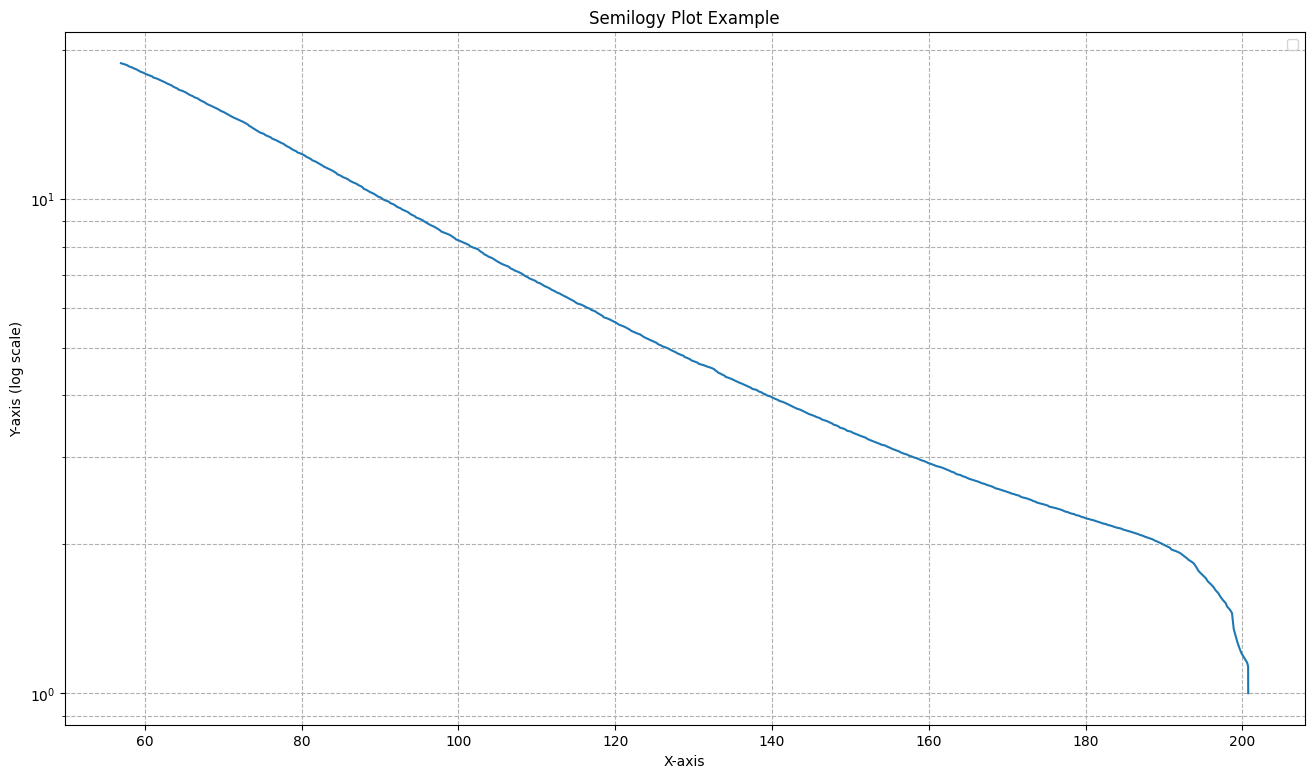

In [13]:
plt.figure(figsize=(16,9))

plt.semilogy(df['Load Pressure (bar)'], df['Resistance (ohm)']/0.04211428139143721, label='')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis (log scale)')
plt.title('Semilogy Plot Example')
plt.legend()

# Display the plot
plt.grid(True, which="both", ls="--")
plt.show()